<a href="https://colab.research.google.com/github/thadduslee/EGARCH-model-XGBoost-optimal-portfolio-construction-Markowitz-Portfolio-Theory-Monte-Carlo/blob/main/Fintech_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import yfinance as yf
import numpy as np
from arch import arch_model
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [87]:
def predict_next_day_volatility(ticker):
  data = yf.download(ticker, start = "1900-01-01")
  data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1)) * 100

  window = 5
  indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=window)
  data["target_volatility"] = data["log_returns"].rolling(window = indexer).std().shift(-1)

  data["volatility_lag_week"] = data["log_returns"].rolling(5).std().shift(1)
  data["volatility_lag_month"] = data["log_returns"].rolling(22).std().shift(1)
  data["volatility_lag_quarter"] = data["log_returns"].rolling(66).std().shift(1)

  data["absolute_returns_lag"] = abs(data["log_returns"].shift(1))
  log_hl = np.log(data["High"] / data["Low"])
  log_co = np.log(data["Close"] / data["Open"])
  data["garman_klass"] = np.sqrt(0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2) * 100

  data["vol_change"] = data["Volume"].pct_change()
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
  data.dropna(inplace = True)

  training = data.iloc[:int(len(data)*0.8)].copy()
  testing = data.iloc[int(len(data)*0.8):].copy()

  training_garch_model = arch_model(training["log_returns"]- training["log_returns"].mean() , vol = "EGARCH", p = 1, q = 1, dist = "t")
  training_garch_model_fit = training_garch_model.fit(disp = "off")
  training["garch_volatility"] = training_garch_model_fit.conditional_volatility


  testing_garch_model = arch_model(testing["log_returns"] - training["log_returns"].mean(), vol = "EGARCH", p = 1, q = 1, dist = "t")
  testing_garch_model_fix = testing_garch_model.fix(training_garch_model_fit.params)
  testing["garch_volatility"] = testing_garch_model_fix.conditional_volatility


  features = ["log_returns", "volatility_lag_week", "volatility_lag_month", "volatility_lag_quarter", "garch_volatility", "absolute_returns_lag", "vol_change", "garman_klass"]

  X_train = training[features]
  y_train = training["target_volatility"]

  X_test = testing[features]
  y_test = testing["target_volatility"]

  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  model = XGBRegressor(learning_rate = 0.01, max_depth = 4, n_estimators = 500, n_jobs = -1, objective = "reg:absoluteerror")
  val_split = int(len(X_train) * 0.9)
  X_tr, X_val = X_train[:val_split], X_train[val_split:]
  y_tr, y_val = y_train[:val_split], y_train[val_split:]

  model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

  y_pred = model.predict(X_test)

  data = pd.concat([training, testing], axis = 0)
  last_row = data.iloc[[-1]][features].copy()
  full_garch = arch_model(data["log_returns"] - data["log_returns"].mean(), vol = "EGARCH", p = 1, q = 1, dist = "t")
  full_garch_fit = full_garch.fix(training_garch_model_fit.params)
  next_day_garch = full_garch_fit.forecast(horizon=1).variance.iloc[-1].values[0]**0.5
  last_row["garch_volatility"] = next_day_garch

  last_row = scaler.transform(last_row)

  predicted_daily_vol = model.predict(last_row)[0]


  annualised_vol = predicted_daily_vol * np.sqrt(252)

  print(f"Daily Vol: {predicted_daily_vol:.4f}% | Annualized: {annualised_vol:.4f}%")
  return annualised_vol

In [88]:
stocks = []
adding = True
while adding:
  temp = input("Enter a stock (Q to quit): ")
  if temp == "Q" or temp == "q":
    adding = False
  else:
    stocks.append(temp.upper()) # Convert to uppercase here
predicted_annual_volatilities = []
for stock in stocks:
  predicted_annual_volatilities.append(predict_next_day_volatility(stock))

price_data = yf.download(stocks, start="1900-01-01")["Close"]
returns_data = np.log(price_data / price_data.shift(1))
returns_data.dropna(inplace = True)
correlation_matrix = returns_data.corr()
correlation_matrix = correlation_matrix.loc[stocks, stocks]
 #get historical correlation

Enter a stock (Q to quit): aapl
Enter a stock (Q to quit): amzn
Enter a stock (Q to quit): q


/tmp/ipython-input-285657755.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "1900-01-01")
[*********************100%***********************]  1 of 1 completed


[0]	validation_0-mae:1.08902
[1]	validation_0-mae:1.08203
[2]	validation_0-mae:1.07516
[3]	validation_0-mae:1.06842
[4]	validation_0-mae:1.06178
[5]	validation_0-mae:1.05524
[6]	validation_0-mae:1.04884
[7]	validation_0-mae:1.04250
[8]	validation_0-mae:1.03623
[9]	validation_0-mae:1.03002
[10]	validation_0-mae:1.02387
[11]	validation_0-mae:1.01780
[12]	validation_0-mae:1.01180
[13]	validation_0-mae:1.00588
[14]	validation_0-mae:1.00007
[15]	validation_0-mae:0.99433
[16]	validation_0-mae:0.98866
[17]	validation_0-mae:0.98299
[18]	validation_0-mae:0.97745
[19]	validation_0-mae:0.97198
[20]	validation_0-mae:0.96651
[21]	validation_0-mae:0.96111
[22]	validation_0-mae:0.95579
[23]	validation_0-mae:0.95055
[24]	validation_0-mae:0.94542
[25]	validation_0-mae:0.94036
[26]	validation_0-mae:0.93536
[27]	validation_0-mae:0.93060
[28]	validation_0-mae:0.92571
[29]	validation_0-mae:0.92084
[30]	validation_0-mae:0.91612
[31]	validation_0-mae:0.91151
[32]	validation_0-mae:0.90697
[33]	validation_0-ma

/tmp/ipython-input-285657755.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "1900-01-01")
[*********************100%***********************]  1 of 1 completed


[0]	validation_0-mae:1.04682
[1]	validation_0-mae:1.04253
[2]	validation_0-mae:1.03777
[3]	validation_0-mae:1.03293
[4]	validation_0-mae:1.02876
[5]	validation_0-mae:1.02452
[6]	validation_0-mae:1.02021
[7]	validation_0-mae:1.01603
[8]	validation_0-mae:1.01170
[9]	validation_0-mae:1.00776
[10]	validation_0-mae:1.00366
[11]	validation_0-mae:0.99966
[12]	validation_0-mae:0.99554
[13]	validation_0-mae:0.99137
[14]	validation_0-mae:0.98727
[15]	validation_0-mae:0.98324
[16]	validation_0-mae:0.97911
[17]	validation_0-mae:0.97504
[18]	validation_0-mae:0.97109
[19]	validation_0-mae:0.96709
[20]	validation_0-mae:0.96335
[21]	validation_0-mae:0.95964
[22]	validation_0-mae:0.95602
[23]	validation_0-mae:0.95247
[24]	validation_0-mae:0.94877
[25]	validation_0-mae:0.94549
[26]	validation_0-mae:0.94243
[27]	validation_0-mae:0.93938
[28]	validation_0-mae:0.93608
[29]	validation_0-mae:0.93284
[30]	validation_0-mae:0.92998
[31]	validation_0-mae:0.92717
[32]	validation_0-mae:0.92409
[33]	validation_0-ma

/tmp/ipython-input-244512424.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(stocks, start="1900-01-01")["Close"]
[*********************100%***********************]  2 of 2 completed


In [89]:
D = np.diag(np.array(predicted_annual_volatilities) / 100)


future_covariance_matrix = D @ correlation_matrix @ D

print("\n--- Future Covariance Matrix (Annualized) ---")
print(future_covariance_matrix)


--- Future Covariance Matrix (Annualized) ---
          0         1
0  0.044422  0.013967
1  0.013967  0.041400


Monte Carlo Simulation (1000 runs)

In [90]:
returns = []
volatilities = []
allocations = []

num_stocks = len(stocks)
num_portfolios = 1000

mean_daily_returns = returns_data.mean()
mean_annual_returns = mean_daily_returns * 252
mean_annual_returns = mean_annual_returns[stocks]

In [91]:
for port in range(num_portfolios):
  w = np.random.random(num_stocks)
  w /= np.sum(w) #make it sum to 1
  allocations.append(w)
  returns.append(np.dot(w, mean_annual_returns))

  var = np.transpose(w).dot(future_covariance_matrix).dot(w)
  standard_deviation = np.sqrt(var)
  volatilities.append(standard_deviation)

In [92]:
data2 = {"Returns":returns, "Volatilities": volatilities}
for counter, symbol in enumerate(stocks):
  data2[symbol + " Weight"] = [allocation[counter] for allocation in allocations]

portfolio = pd.DataFrame(data2)
portfolio

,Returns,Volatilities,AAPL Weight,AMZN Weight
0,0.269705,0.169407,0.545777,0.454223
1,0.269918,0.168573,0.491135,0.508865
2,0.271352,0.188439,0.123434,0.876566
3,0.268883,0.181737,0.756671,0.243329
4,0.271776,0.201524,0.014579,0.985421
...,...,...,...,...
995,0.268968,0.179833,0.734797,0.265203
996,0.270378,0.170252,0.373269,0.626731
997,0.269670,0.169638,0.554656,0.445344
998,0.269723,0.169298,0.541230,0.458770


Below is a plot of the efficient frontier

<Axes: xlabel='Volatilities', ylabel='Returns'>

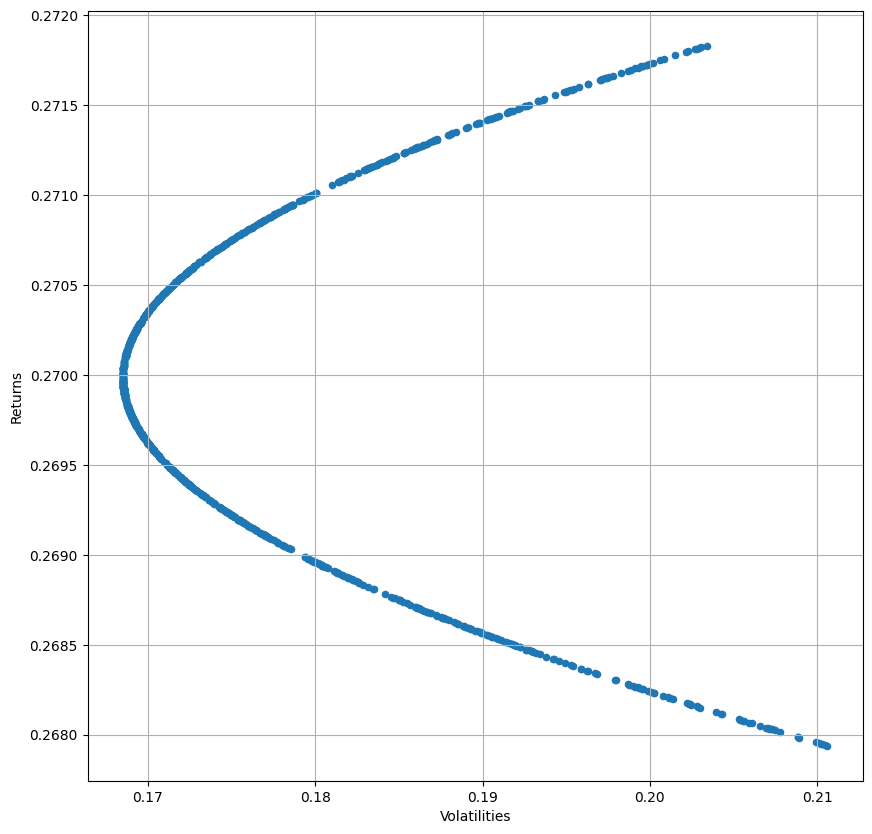

In [93]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)


In [94]:
risk_free_rate = 0.04
highest_sharpe_ratio = portfolio.iloc[((portfolio["Returns"] - risk_free_rate)/portfolio["Volatilities"]).idxmax()]
highest_sharpe_ratio

,774
Returns,0.270018
Volatilities,0.168534
AAPL Weight,0.465412
AMZN Weight,0.534588


The portfolio with the highest sharpe ratio is marked below with a star

/tmp/ipython-input-2200269511.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


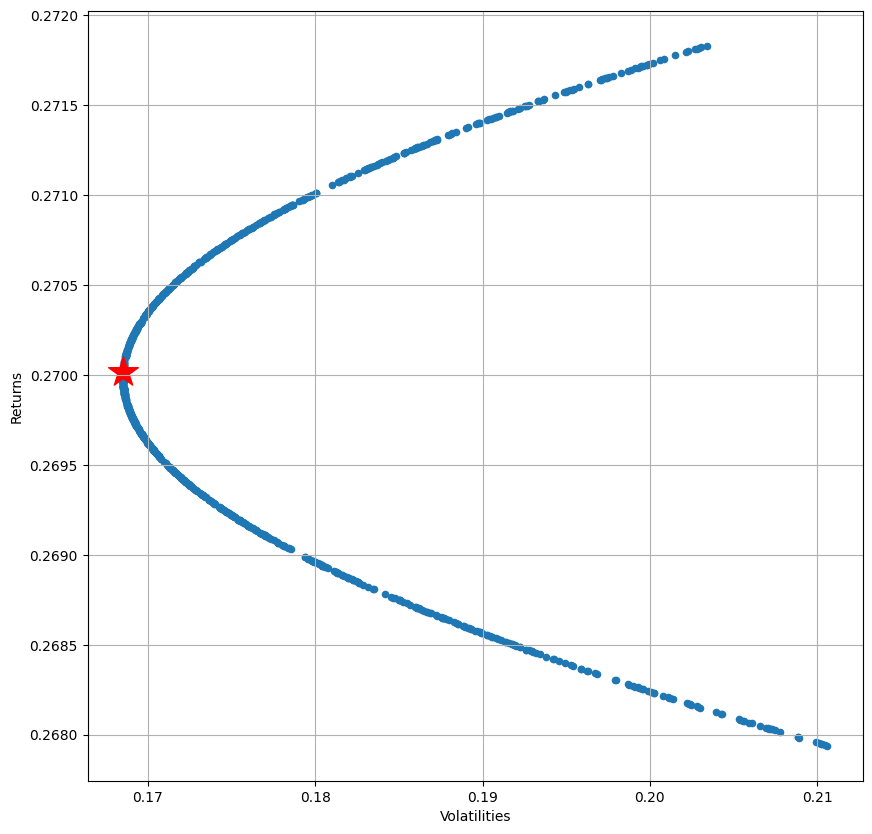

In [95]:
portfolio.plot.scatter(x = 'Volatilities', y = "Returns", figsize = (10,10), grid = True)
plt.scatter(x = highest_sharpe_ratio[1], y = highest_sharpe_ratio[0], color = "red", marker = "*", s = 500)


In [96]:
print(f"The expected returns for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[0]*100}%")
print(f"The volatility for the portfolio with the highest sharpe ratio is: {highest_sharpe_ratio.iloc[1]*100}%")


The expected returns for the portfolio with the highest sharpe ratio is: 27.00182540401831%
The volatility for the portfolio with the highest sharpe ratio is: 16.85338274958616%
